In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/reviews.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Display the first few rows of the dataset
print(df.head())

   Unnamed: 0   Airline Name Overall_Rating  \
0           0    AB Aviation              9   
1           1    AB Aviation              1   
2           2    AB Aviation              1   
3           3  Adria Airways              1   
4           4  Adria Airways              1   

                            Review_Title          Review Date  Verified  \
0                "pretty decent airline"   11th November 2019      True   
1                   "Not a good airline"       25th June 2019      True   
2         "flight was fortunately short"       25th June 2019      True   
3    "I will never fly again with Adria"  28th September 2019     False   
4  "it ruined our last days of holidays"  24th September 2019      True   

                                              Review       Aircraft  \
0    Moroni to Moheli. Turned out to be a pretty ...            NaN   
1   Moroni to Anjouan. It is a very small airline...           E120   
2    Anjouan to Dzaoudzi. A very small airline an... 

In [ ]:
# Cleaning the dataset
# Check for missing values
print(df.isnull().sum())

Unnamed: 0                    0
Airline Name                  0
Overall_Rating                0
Review_Title                  0
Review Date                   0
Verified                      0
Review                        0
Aircraft                  16042
Type Of Traveller          3738
Seat Type                  1096
Route                      3828
Date Flown                 3754
Seat Comfort               4155
Cabin Staff Service        4260
Food & Beverages           8671
Ground Service             4793
Inflight Entertainment    12342
Wifi & Connectivity       17251
Value For Money            1066
Recommended                   0
dtype: int64


In [ ]:
# Check for missing values
df.isnull().sum()

# Drop rows with missing values
df.dropna(subset=['Review'], inplace=True)


In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the cleaning function to the review column
df['cleaned_review'] = df['Review'].apply(clean_text)

# Display the cleaned text
df[['Review', 'cleaned_review']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Review,cleaned_review
0,Moroni to Moheli. Turned out to be a pretty ...,moroni moheli turned pretty decent airline onl...
1,Moroni to Anjouan. It is a very small airline...,moroni anjouan small airline ticket advised tu...
2,Anjouan to Dzaoudzi. A very small airline an...,anjouan dzaoudzi small airline airline based c...
3,Please do a favor yourself and do not fly wi...,please favor fly adria route munich pristina j...
4,Do not book a flight with this airline! My fr...,book flight airline friend returned sofia amst...


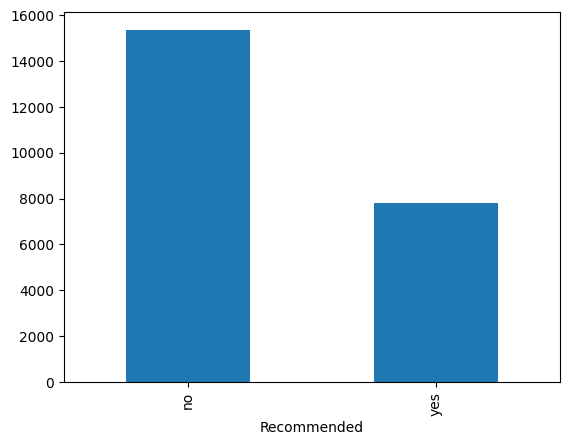

In [ ]:
# Basic statistics
df.describe()

# Count of reviews per sentiment (if applicable)
if 'Recommended' in df.columns:
    df['Recommended'].value_counts().plot(kind='bar')



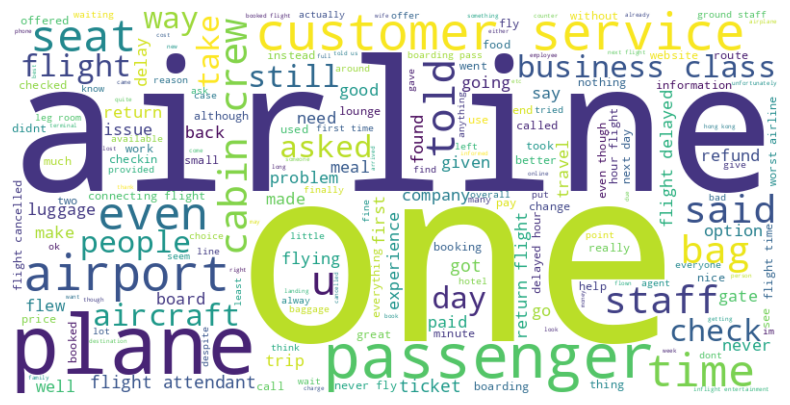

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_review']))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Apply the lemmatization function
df['lemmatized_review'] = df['cleaned_review'].apply(lemmatize_text)

# Display the lemmatized text
df[['cleaned_review', 'lemmatized_review']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,cleaned_review,lemmatized_review
0,moroni moheli turned pretty decent airline onl...,moroni moheli turned pretty decent airline onl...
1,moroni anjouan small airline ticket advised tu...,moroni anjouan small airline ticket advised tu...
2,anjouan dzaoudzi small airline airline based c...,anjouan dzaoudzi small airline airline based c...
3,please favor fly adria route munich pristina j...,please favor fly adria route munich pristina j...
4,book flight airline friend returned sofia amst...,book flight airline friend returned sofia amst...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
text_matrix = vectorizer.fit_transform(df['lemmatized_review'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_matrix)

# Display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
flight seat crew good service food time cabin airline meal
Topic 1:
flight day airline customer service ticket refund time email airport
Topic 2:
flight hour airline time delayed delay plane airport passenger pm
Topic 3:
seat airline flight pay ticket extra service paid price cost
Topic 4:
bag flight luggage check boarding airport staff told plane gate


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'Recommended' is the target variable for sentiment (1 for positive, 0 for negative)
X = df['lemmatized_review']
y = df['Recommended']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create a pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english')),
    ('clf', LogisticRegression())
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.9005393743257821
              precision    recall  f1-score   support

          no       0.91      0.94      0.93      3064
         yes       0.88      0.82      0.85      1571

    accuracy                           0.90      4635
   macro avg       0.89      0.88      0.89      4635
weighted avg       0.90      0.90      0.90      4635

